In [1]:
%load_ext cython

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np

In [3]:
from tqdm import tqdm

In [4]:
%%cython -+ 
cimport cython
import numpy as np
cimport numpy as np

from libc.math cimport exp, tanh
from mc_lib.rndm cimport RndmWrapper
from mc_lib.lattices import tabulate_neighbors
from mc_lib.observable cimport RealObservable
    
cdef void init_spins(long[::1] spins, RndmWrapper rndm): 
    
    for j in range(spins.shape[0]):
        spins[j] = 1 if rndm.uniform() > 0.5 else -1
        
        
        
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double energy(long[::1] spins, 
                   long[:, ::1] neighbors,
                  const double[:,::1] Js):

    cdef:
        double ene = 0.0
        Py_ssize_t site, site1, num_neighb

    for site in range(spins.shape[0]):
        num_neighb = neighbors[site, 0]
        for j in range(1, num_neighb+1):
            site1 = neighbors[site, j]
            ene += -1 * Js[site, site1] * spins[site] * spins[site1] 
    
    return ene / 2.0



@cython.boundscheck(False)
@cython.wraparound(False)
cdef void flip_spin(long[::1] spins, 
                    const long[:, ::1] neighbors,
                    double beta,
                    const double[:,::1] Js, RndmWrapper rndm): 
    cdef:
        Py_ssize_t site = int(spins.shape[0] * rndm.uniform())
        Py_ssize_t site1

    cdef long num_neighb = neighbors[site, 0]
    cdef double summ = 0.
    for j in range(1, num_neighb + 1):
        site1 = neighbors[site, j]
        summ += spins[site1] * spins[site] * Js[site,site1]
   
    cdef double ratio = exp(-2.0 * beta * summ )
    
    if rndm.uniform() > ratio:
        return

    spins[site] = -spins[site]
    
    
cdef void get_J( double[:,::1] Js, double J, double Jd, int L1, int L2):
    
    for i in range(L1*L2):
        Js[i, ((i // L2 + 1) % L1 * L2 )  + (i + 1) % L2 ] = Jd
        Js[i, ((i // L2  - 1) % L1 * L2 )  + (i - 1) % L2 ] = Jd
        Js[i, (i // L2) * L2 + (i + 1) % L2] = J 
        Js[i, (i + L2) % (L1*L2)] = J
        Js[i, (i // L2) * L2 + (i - 1) % L2] = J
        Js[i, (i - L2) % (L1*L2)] = J
    return
        

def simulate(Py_ssize_t L,
             double T, double J, double Jd,
             Py_ssize_t num_sweeps, int seed, int rseed = 1234):

    cdef:
        long[:, ::1] neighbors = tabulate_neighbors(L, kind='triang') 
        double beta = 1./T

    cdef:
        
        int num_therm = int(1e2 * L * L)
        int steps_per_sweep = L * L 
        int sweep = 0
        int i
        double Z = 0., magn = 0., av_magn_2=0., av_magn_4 = 0., binder = 0., av_en = 0
        
    
    cdef RndmWrapper rndm = RndmWrapper((rseed, seed))    

    cdef long[::1] spins =  np.empty( L*L, dtype=int) 
    init_spins(spins, rndm)
    
    cdef double[:,::1] Js = np.zeros((L*L, L*L)) 
    get_J(Js, J, Jd, L, L)

    for sweep in range(num_therm):
        for i in range(steps_per_sweep):
            flip_spin(spins, neighbors, beta, Js, rndm)

    for sweep in range(num_sweeps):
        for i in range(steps_per_sweep):
            flip_spin(spins, neighbors, beta, Js, rndm)
            
        Z += 1
        magn = 0.
        for i in range(L*L):
            magn += spins[i]
        av_magn_2 += magn**2
        av_magn_4 += magn**4
        
    binder = 1 - (av_magn_4 / Z) / (3 * (av_magn_2 / Z)**2)
     
    return binder 
  

In [5]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  44


In [6]:
from multiprocessing import Pool
import os

In [7]:
def cums(data):
    
    Temps = data[0]
    Jd = data[1]
    T = len(Temps)

    b_10 = np.zeros(T)
    b_20 = np.zeros(T)
    b_40 = np.zeros(T)
    
    pid = os.getpid()
    
    for j,t in enumerate(Temps):
        b_10[j] = simulate(10,t,1,Jd,int(2e6),pid,j) # меняю rseed. мне кажется, надо менять
        b_20[j] = simulate(20,t,1,Jd,int(2e6),pid,j)
        b_40[j] = simulate(40,t,1,Jd,int(2e6),pid,j)
        print("прошло ~", j*6 + 6, " минут из 120")
        
    return [ b_10, b_20 ,b_40]


все процессы делают измерения одной и той же величины отдельно. Затем они усредняются

Найдем область пересечения графиков Binder cumulant для различных размеров решетки.
При Jd = 0 она должна включать окрестность Tс =  2.269.

In [ ]:
%%time
Temps = np.linspace(2.2, 2.3, 20)
Jd = 0

N = 10
T = len(Temps)
data = list(zip([Temps]*N, [Jd]*N))

pool = Pool(N)

res = pool.map(cums, data)
res = np.asarray(res)

binder_10 = np.zeros((N,T))
binder_20 = np.zeros((N,T))
binder_40 = np.zeros((N,T))

for i in range(N):
    binder_10[i] = res[i,0]
    binder_20[i] = res[i,1]
    binder_40[i] = res[i,2]
    
pool.close() 
pool.join() 

In [30]:
binder10_0 = []
binder20_0 = []
binder40_0 = []
er10_0 = []
er20_0 = []
er40_0 = []
for t in range(T):
    binder10_0.append(np.mean( [binder_10[i,t] for i in range(N)] ))
    er10_0.append(np.std( [binder_10[i,t] for i in range(N)] ))
    
    binder20_0.append(np.mean( [binder_20[i,t] for i in range(N)] ))
    er20_0.append(np.std( [binder_20[i,t] for i in range(N)] ))
    
    binder40_0.append(np.mean( [binder_40[i,t] for i in range(N)] ))
    er40_0.append(np.std( [binder_40[i,t] for i in range(N)] ))
    

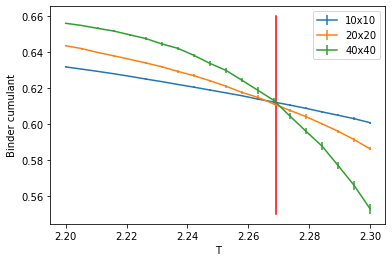

In [36]:
plt.errorbar(Temps, binder10_0, yerr = er10_0, label = '10x10')
plt.errorbar(Temps, binder20_0, yerr = er20_0, label = '20x20')
plt.errorbar(Temps, binder40_0, yerr = er40_0, label = '40x40')
plt.plot([2.269]*20, np.linspace(0.55,0.66,20), c = 'r')
plt.legend()

plt.xlabel("T")
plt.ylabel("Binder cumulant")
plt.show()

При Jd = -0.1 Tc = 2.105 из уравнения. 

In [ ]:
Temps = np.linspace(2.06, 2.14, 20)
Jd = -0.1

N = 10
T = len(Temps)
data = list(zip([Temps]*N, [Jd]*N))

pool = Pool(N)

res = pool.map(cums, data)
res = np.asarray(res)

binder_10 = np.zeros((N,T))
binder_20 = np.zeros((N,T))
binder_40 = np.zeros((N,T))

for i in range(N):
    binder_10[i] = res[i,0]
    binder_20[i] = res[i,1]
    binder_40[i] = res[i,2]
    
pool.close() 
pool.join() 

In [9]:
binder10_01 = []
binder20_01 = []
binder40_01 = []
er10_01 = []
er20_01 = []
er40_01 = []
for t in range(T):
    binder10_01.append(np.mean( [binder_10[i,t] for i in range(N)] ))
    er10_01.append(np.std( [binder_10[i,t] for i in range(N)] ))
    
    binder20_01.append(np.mean( [binder_20[i,t] for i in range(N)] ))
    er20_01.append(np.std( [binder_20[i,t] for i in range(N)] ))
    
    binder40_01.append(np.mean( [binder_40[i,t] for i in range(N)] ))
    er40_01.append(np.std( [binder_40[i,t] for i in range(N)] ))
    

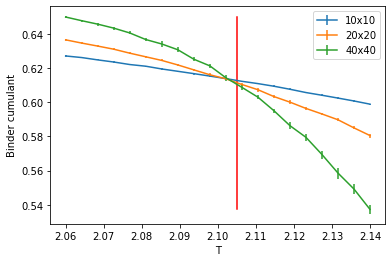

In [14]:
plt.errorbar(Temps, binder10_01, yerr = er10_01, label = '10x10')
plt.errorbar(Temps, binder20_01, yerr = er20_01, label = '20x20')
plt.errorbar(Temps, binder40_01, yerr = er40_01, label = '40x40')
plt.plot([2.105]*20, np.linspace(binder40_01[0],binder40_01[-1],20), c = 'r')
plt.legend()

plt.xlabel("T")
plt.ylabel("Binder cumulant")
plt.show()

In [12]:
print(er10_01)
print(er20_01)
print(er40_01)

[0.00036367473204635054, 0.00018221224745596323, 0.0002380119030245667, 0.0003002389593892083, 0.0003935230911994577, 0.00033720131379861727, 0.0004166577591671151, 0.0004419725713979129, 0.000513060448266462, 0.0002548446105527416, 0.0004924511205703515, 0.00040468442651808413, 0.0003676578525800968, 0.0004653154032562086, 0.0006619353496788499, 0.0005067867062648289, 0.0006417355271388508, 0.00037432951367827376, 0.0004441625204302653, 0.0003330975003162161]
[0.000491835136829285, 0.0006009311420703133, 0.0005097666526976031, 0.0006069657760883162, 0.0006454335757875373, 0.000724219927261954, 0.0005688162017525059, 0.0006394478199678419, 0.000533289263557345, 0.0007554909534125327, 0.0006822043507705978, 0.0009264631825121899, 0.001061385117889879, 0.0008216245204800283, 0.0012567307819256223, 0.0008389650665179488, 0.0008470471562359551, 0.000942417663011055, 0.0008406421101636624, 0.001145456014348097]
[0.0004615255838600283, 0.0006635915847557238, 0.0008975474022416814, 0.00091823

In [15]:
print(binder10_01)
print(binder20_01)
print(binder40_01)

[0.6270740775856353, 0.6261476677906155, 0.6247773295539264, 0.6235369515342075, 0.62206302456095, 0.6210762059759107, 0.6194642785178152, 0.6181052488133127, 0.6167335418603898, 0.6153027425868673, 0.6138182563209986, 0.6122434058501011, 0.6109004749091329, 0.6093656517912629, 0.6075920122404758, 0.605662996960728, 0.6040842862127789, 0.6024237167892149, 0.6007255565924902, 0.5988589894225663]
[0.6365157784710936, 0.6346206748687293, 0.632867327389133, 0.6310434771152792, 0.6287164104959524, 0.6265893741928873, 0.6244597726249377, 0.6218221889172572, 0.6189396358815829, 0.6160785580275869, 0.6136905258769494, 0.6103772059434565, 0.6073238970218269, 0.6033180409809031, 0.6000471035069561, 0.5963669710088311, 0.5931211625581916, 0.5897281278888667, 0.5849649912713518, 0.5804819089801272]
[0.6498666549762049, 0.6477189917201034, 0.645703772373216, 0.6433740519555413, 0.6405478771914724, 0.6366910107316253, 0.634088007010685, 0.6307208245139978, 0.6251766720661124, 0.6212814667100591, 0.6

Jd = -0.3, Tc = 1.749

In [ ]:
Temps = np.linspace(1.71, 1.79, 20)
Jd = -0.3

N = 10
T = len(Temps)
data = list(zip([Temps]*N, [Jd]*N))

pool = Pool(N)

res = pool.map(cums, data)
res = np.asarray(res)

binder_10 = np.zeros((N,T))
binder_20 = np.zeros((N,T))
binder_40 = np.zeros((N,T))

for i in range(N):
    binder_10[i] = res[i,0]
    binder_20[i] = res[i,1]
    binder_40[i] = res[i,2]
    
pool.close() 
pool.join() 

In [23]:
binder10_03 = []
binder20_03 = []
binder40_03 = []
er10_03 = []
er20_03 = []
er40_03 = []
for t in range(T):
    binder10_03.append(np.mean( [binder_10[i,t] for i in range(N)] ))
    er10_03.append(np.std( [binder_10[i,t] for i in range(N)] ))
    
    binder20_03.append(np.mean( [binder_20[i,t] for i in range(N)] ))
    er20_03.append(np.std( [binder_20[i,t] for i in range(N)] ))
    
    binder40_03.append(np.mean( [binder_40[i,t] for i in range(N)] ))
    er40_03.append(np.std( [binder_40[i,t] for i in range(N)] ))
    

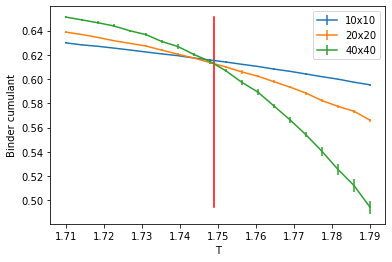

In [24]:
plt.errorbar(Temps, binder10_03, yerr = er10_03, label = '10x10')
plt.errorbar(Temps, binder20_03, yerr = er20_03, label = '20x20')
plt.errorbar(Temps, binder40_03, yerr = er40_03, label = '40x40')
plt.plot([1.749]*20, np.linspace(binder40_03[0],binder40_03[-1],20), c = 'r')
plt.legend()

plt.xlabel("T")
plt.ylabel("Binder cumulant")
plt.show()

In [25]:
print(er10_03)
print(er20_03)
print(er40_03)
print(binder10_03)
print(binder20_03)
print(binder40_03)

[0.00047381795338983764, 0.0004913365609941002, 0.000346597820037584, 0.0002056635037816552, 0.00033586231219514374, 0.0002807582963292948, 0.0004637800152241236, 0.00036652986639408103, 0.00034611382654140677, 0.00043200826152102456, 0.0004810707951217187, 0.0004646733811594592, 0.00040631863113837303, 0.0004670584843679576, 0.0003816876757955198, 0.0004595657329177079, 0.0003615544446913053, 0.0003962223042279639, 0.0005070091534254313, 0.0005730601287551675]
[0.0006445484992620788, 0.00047242938792319456, 0.0004908672023762698, 0.0004918761470036049, 0.0006765017670597994, 0.0007629667129439848, 0.0005736820010298193, 0.0009303215498522972, 0.0007772255378925993, 0.0010665501786050104, 0.0008178269536106726, 0.0014800068085814827, 0.0009688514202037958, 0.0013581784401963527, 0.0010519589150241287, 0.0012310649839067152, 0.0009694594444333217, 0.0011425357327877125, 0.0013926271394578903, 0.0011746822464262713]
[0.0006838077917912371, 0.0005381885369028153, 0.001082981414623791, 0.0

При Jd = -0.5 Tc = 1.342 

In [ ]:
Temps = np.linspace(1.30, 1.38, 20)
Jd = -0.5

N = 10
T = len(Temps)
data = list(zip([Temps]*N, [Jd]*N))

pool = Pool(N)

res = pool.map(cums, data)
res = np.asarray(res)

binder_10 = np.zeros((N,T))
binder_20 = np.zeros((N,T))
binder_40 = np.zeros((N,T))

for i in range(N):
    binder_10[i] = res[i,0]
    binder_20[i] = res[i,1]
    binder_40[i] = res[i,2]
    
pool.close() 
pool.join() 

In [17]:
binder10_05 = []
binder20_05 = []
binder40_05 = []
er10_05 = []
er20_05 = []
er40_05 = []
for t in range(T):
    binder10_05.append(np.mean( [binder_10[i,t] for i in range(N)] ))
    er10_05.append(np.std( [binder_10[i,t] for i in range(N)] ))
    
    binder20_05.append(np.mean( [binder_20[i,t] for i in range(N)] ))
    er20_05.append(np.std( [binder_20[i,t] for i in range(N)] ))
    
    binder40_05.append(np.mean( [binder_40[i,t] for i in range(N)] ))
    er40_05.append(np.std( [binder_40[i,t] for i in range(N)] ))
    

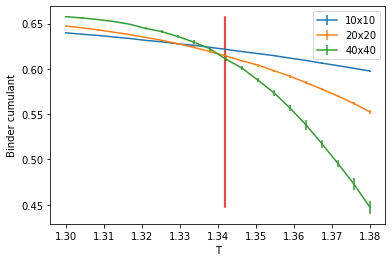

In [21]:
plt.errorbar(Temps, binder10_05, yerr = er10_05, label = '10x10')
plt.errorbar(Temps, binder20_05, yerr = er20_05, label = '20x20')
plt.errorbar(Temps, binder40_05, yerr = er40_05, label = '40x40')
plt.plot([1.342]*20, np.linspace(binder40_05[0],binder40_05[-1],20), c = 'r')
plt.legend()

plt.xlabel("T")
plt.ylabel("Binder cumulant")
plt.show()

In [19]:
print(er10_05)
print(er20_05)
print(er40_05)

[0.0004084557310497146, 0.0002589391748333518, 0.00027913793936716787, 0.00026853377198367864, 0.00045663582650178644, 0.0003837391158046031, 0.0004286823498390162, 0.00026748746454987893, 0.00018688721508982882, 0.00048771051708929486, 0.00043144763594548356, 0.0005802117767018891, 0.0006132499845176705, 0.0005223937890859986, 0.0003861760941808456, 0.0009303934167969898, 0.0007488294871044311, 0.0006037376569057141, 0.0004940295472010143, 0.0005302565265260095]
[0.0006287129590041308, 0.00022359597620612648, 0.0007082205956255727, 0.00061507617378989, 0.0008084790154632976, 0.0005076371265430711, 0.0004147789894772624, 0.0007369381963392528, 0.0011884375864886858, 0.0012076101046394623, 0.0007540755106406034, 0.0012253245707151532, 0.001579274866609433, 0.0010271039439734297, 0.0017809898456982226, 0.001416339034962244, 0.001097857407616138, 0.0012634520367503744, 0.0013044665452613255, 0.001957273519018596]
[0.00046362291004870346, 0.000789365026595207, 0.0005825237997613868, 0.0006

In [20]:
print(binder10_05)
print(binder20_05)
print(binder40_05)

[0.6397877006458312, 0.638233818103306, 0.6368925144851161, 0.6351929516583746, 0.633526990864917, 0.6314267652891463, 0.6298740633798745, 0.6276117573897166, 0.626040076869668, 0.6237646703882366, 0.6215151491959083, 0.6190786862042204, 0.6168842393379903, 0.6146267486736017, 0.6118629923239727, 0.6093028600273949, 0.6062833903839144, 0.6035418010451843, 0.6005640045938205, 0.5975789836091205]
[0.64720667432061, 0.6453059794890932, 0.6430133188454843, 0.640520046248764, 0.637734242371305, 0.6347088503728961, 0.6315356274357036, 0.627814287075532, 0.6236604905558519, 0.6191986816721755, 0.6142180352264173, 0.6089174065217252, 0.6041760230795025, 0.598010941023708, 0.5919212906225193, 0.5847663903586993, 0.5775321321007876, 0.5699838739011882, 0.5617225274639497, 0.5525667614414145]
[0.6575982448959549, 0.6561947512599782, 0.6544102889227036, 0.652273614825002, 0.6492383620782863, 0.6445624852838718, 0.6411167013392616, 0.6357221004569577, 0.629522673041442, 0.6221812289676313, 0.610700